In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import numpy as np
import pprint
import sqlite3
import math
from tqdm import tqdm
from datetime import datetime
from Offline.strategies.ml_based_strategy_latest_回归策略_join_分类 import CustomMLStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer

from Share.database_auto.db_data_downloader.downloader_base import DownloaderBase
import Share.database_auto.database_config as db_config

In [2]:
BACKTEST_INDEX_SYMBOLS = "000016"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身
# ---- 回归任务
model_pred_df = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_2019-01-01_回归任务_v5.pkl')
# class_pred_df = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_2019-01-01_分类任务_v6.pkl')
# model_pred_df = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_2019-01-01_分类任务_v6.pkl')
class_pred_df = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_2019-01-01_三分类任务_v6.pkl')
class_pred_df = class_pred_df.rename(columns={'label_pred_1':'label_pred'})

In [3]:
# class_pred_df1 = class_pred_df[class_pred_df['label_pred']<0.44089862108230593][['stock_code', 'datetime']]

down_score = model_pred_df['label_pred'].quantile(0.9)
class_pred_df['flag'] = class_pred_df['label_pred']>down_score

model_pred_df = pd.merge(model_pred_df, class_pred_df[['stock_code', 'datetime', 'flag']], on=['stock_code', 'datetime'], how='inner')


model_pred_df.head()

,stock_code,stock_name,datetime,label,label_pred,flag
0,sh.600028,中国石化,2019-01-02,0.564382,0.465099,False
1,sh.600028,中国石化,2019-01-03,0.563441,0.403107,False
2,sh.600028,中国石化,2019-01-04,0.548934,0.391665,False
3,sh.600028,中国石化,2019-01-07,0.537382,0.380563,False
4,sh.600028,中国石化,2019-01-08,0.532780,0.386130,False


In [4]:
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].unique().tolist()
print(BACKTEST_STOCK_SYMBOLS)
BACKTEST_START_DATE = model_pred_df['datetime'].min()  # 回测开始日期
BACKTEST_END_DATE = model_pred_df['datetime'].max()  # 回测结束日期
print(f'StartDate: {BACKTEST_START_DATE}, EndDate: {BACKTEST_END_DATE}')

['sh.600028', 'sh.600030', 'sh.600031', 'sh.600036', 'sh.600048', 'sh.600050', 'sh.600089', 'sh.600104', 'sh.600111', 'sh.600150', 'sh.600276', 'sh.600309', 'sh.600406', 'sh.600436', 'sh.600438', 'sh.600519', 'sh.600690', 'sh.600809', 'sh.600887', 'sh.600893', 'sh.600900', 'sh.600905', 'sh.601012', 'sh.601088', 'sh.601166', 'sh.601225', 'sh.601288', 'sh.601318', 'sh.601390', 'sh.601398', 'sh.601601', 'sh.601628', 'sh.601633', 'sh.601668', 'sh.601669', 'sh.601728', 'sh.601857', 'sh.601888', 'sh.601899', 'sh.601919', 'sh.601988', 'sh.603259', 'sh.603288', 'sh.603501', 'sh.603799', 'sh.603986', 'sh.688041', 'sh.688111', 'sh.688599', 'sh.688981']
StartDate: 2019-01-02, EndDate: 2024-04-17


In [5]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database_auto/hh_quant_auto.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)
dd = db_downloader._download_all_stock_info()
dd[dd['code'] == f'sh.{BACKTEST_INDEX_SYMBOLS}']

,code,code_name,in_date,out_date,type,status,industry
985,sh.000016,上证50指数,2004-01-02,,指数,上市,None


In [6]:
# 初始化backtrader相关参数
cerebro = bt.Cerebro()
BACKTEST_INITIAL_CASH = 200000  # 初始化资金

print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型
cerebro.broker.set_slippage_perc(perc=0.0001) # 配置自定义的滑点类型

# 获取回测区间的所有交易日期来构建统一的Index索引
BACKTEST_DATETIME_INDEX = pd.to_datetime(sorted(model_pred_df['datetime'].unique()))

print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_history_base_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data = stock_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

print("开始添加基准数据...")
BENCHMARK_SYMBOLS = 'sh.' + BACKTEST_INDEX_SYMBOLS
benchmark_data = db_downloader._download_history_base_info(BENCHMARK_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data = benchmark_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
benchmark_name = f"benchmark_{BENCHMARK_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器

# print("开始添加观察器...")
# cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

开始设置回测基础参数...
开始添加回测股票数据...


 36%|███▌      | 18/50 [00:00<00:00, 169.21it/s]

100%|██████████| 50/50 [00:00<00:00, 180.21it/s]

开始添加基准数据...
开始添加分析器...


In [7]:
print("开始添加策略...")
strategy_params = {
    "benchmark": benchmark_name,
    "model_pred_dataframe": model_pred_df,
}

lower_bound, upper_boumd = np.nanquantile(model_pred_df['label_pred'], [0.2, 0.8])
strategy_params.update(
    {
        "max_position_proportion": 0.15,  # 最大持仓资金占比
        "min_holding_period": 0,  # 最小持仓周期
        "max_holding_period": 20,  # 最大持仓周期
        "top_n": 5,  # 每日选择股票的TopN
        "min_buy_cash": 2000,  # 最小购买资金限制
        "atr_period": 14,  # ATR计算周期
         "init_trailing_stop_loss_factor": 1.5,  # 首次买入跟踪止损位 = 1.5ATR
        "update_trailing_stop_loss_factor": 1,  # 更新跟踪止损位 = 1ATR
        "atr_risk": 0.05,  # ATR风险系数
        "buy_pred_upper_bound": upper_boumd,
        "sell_pred_lower_bound": lower_bound
    }
)

cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...


0

In [8]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...


启动基准对比...
回测数据共: 50
current_date: 2019-01-02 ================================================================================
current_cash: 200000.0
2019-01-03 买入执行, 引用: 1, 价格: 11.36, 成本: 30666.16, 手续费: 5.00, 数量: 2700.00, 股票: sh.600028
2019-01-03 买入执行, 引用: 2, 价格: 5.60, 成本: 6160.07, 手续费: 5.00, 数量: 1100.00, 股票: sh.601899
2019-01-03 买入执行, 引用: 3, 价格: 41.44, 成本: 16575.38, 手续费: 5.00, 数量: 400.00, 股票: sh.603799
2019-01-03 买入执行, 引用: 4, 价格: 66.83, 成本: 26730.67, 手续费: 5.00, 数量: 400.00, 股票: sh.600893
2019-01-03 买入执行, 引用: 5, 价格: 28.87, 成本: 8662.05, 手续费: 5.00, 数量: 300.00, 股票: sh.603501
current_date: 2019-01-03 ================================================================================
current_cash: 111180.68145599999
2019-01-04 买入执行, 引用: 6, 价格: 28.11, 成本: 5622.52, 手续费: 5.00, 数量: 200.00, 股票: sh.603501
2019-01-04 买入执行, 引用: 7, 价格: 19.34, 成本: 7735.69, 手续费: 5.00, 数量: 400.00, 股票: sh.601633
2019-01-04 买入执行, 引用: 8, 价格: 5.75, 成本: 4601.10, 手续费: 5.00, 数量: 800.00, 股票: sh.601899
2019-01-04 买入执行, 引用: 9, 价格: 3

开始打印回测相关指标...
Start Portfolio Value: 200000
Final Portfolio Value: 1193713.3653077425
{'其他': {'亏损次数': 468,
        '夏普比率': 1.9622,
        '日均超额收益': 0.0013,
        '日胜率': 0.5429,
        '最大回撤': 13.2055,
        '最大回撤区间': 0,
        '盈亏比': 3.4347,
        '盈利次数': 326,
        '索提诺比率': 3.1297,
        '胜率': 0.4106,
        '贝塔': 0.5943,
        '超额收益': 4.8903,
        '超额收益夏普比率': 1.9902,
        '阿尔法': 0.0014},
 '基准': {'基准年化收益': 0.0149, '基准收益': 0.0783, '基准波动率': 0.1908},
 '策略': {'策略年化收益': 0.4203, '策略收益': 4.9686, '策略波动率': 0.1881}}


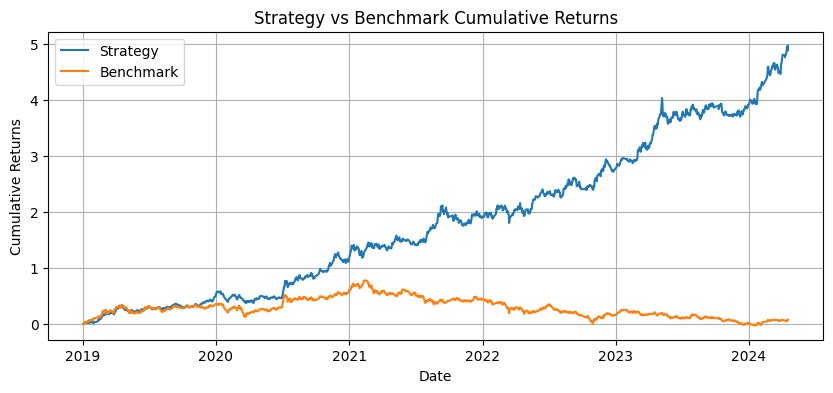

In [9]:
print("开始打印回测相关指标...")
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.get_value()}")

def plot_strategy_benchmark_returns(strategy_returns, benchmark_returns):
    import matplotlib.pyplot as plt
    # 检查index是否一致以保证对齐
    if not strategy_returns.index.equals(benchmark_returns.index):
        raise ValueError("Indexes of strategy_returns and benchmark_returns must match")
    # 计算累积收益率
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1
    # 绘制累积收益率曲线
    plt.figure(figsize=(10,4))
    plt.plot(strategy_cumulative_returns, label='Strategy')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    # 添加标题和标签
    plt.title('Strategy vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    # 显示图例
    plt.legend()
    # 显示网格
    plt.grid(True)
    # 显示绘制的图形
    plt.show()

custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

strategy_returns = pd.Series(results[0].analyzers.custom_analyzer.get_strategy_returns(), index=benchmark_data.index[1:])
benchmark_returns = pd.Series(results[0].analyzers.custom_analyzer.get_benchmark_returns(), index=benchmark_data.index[1:])
plot_strategy_benchmark_returns(strategy_returns, benchmark_returns)

In [10]:
annual_strategy_returns = strategy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_benchmark_returns = benchmark_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns = pd.concat([annual_strategy_returns, annual_benchmark_returns], axis=1)
annual_returns.columns = ['Strategy', 'Benchmark']
annual_returns['Gap'] = annual_returns['Strategy'] - annual_returns['Benchmark']
annual_returns

,Strategy,Benchmark,Gap
2019-12-31,0.502262,0.353735,0.148527
2020-12-31,0.441596,0.188501,0.253095
2021-12-31,0.345904,-0.100619,0.446524
2022-12-31,0.290518,-0.195177,0.485695
2023-12-31,0.305608,-0.117285,0.422893
2024-12-31,0.215318,0.048871,0.166447


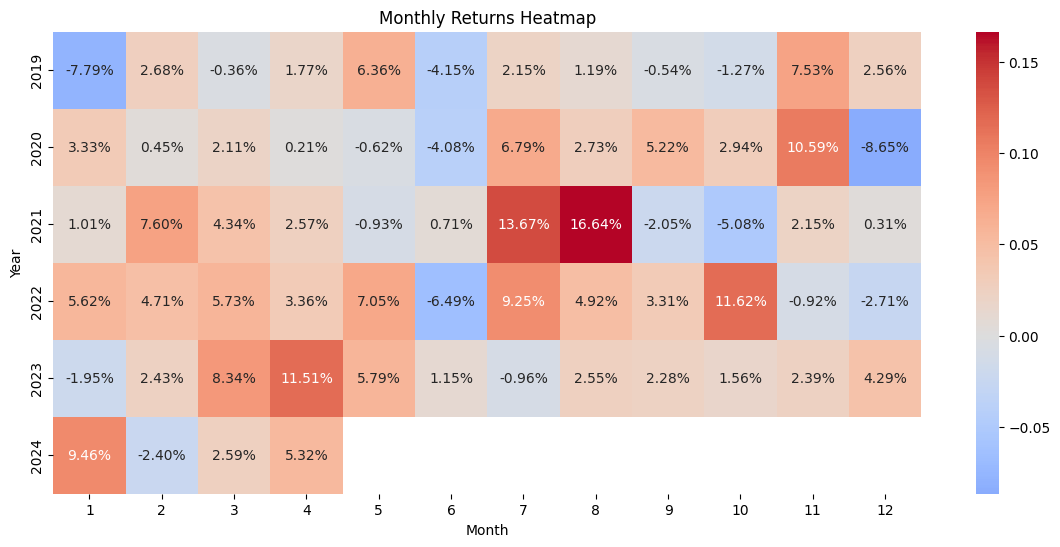

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 monthly_returns 是一个包含月度收益率的Series，并且它的索引是DateTimeIndex
# 如果它不是DataFrame，我们先将其转换成DataFrame
strategy_monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
benchmark_monthly_returns = benchmark_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
gap_monthly = strategy_monthly_returns - benchmark_monthly_returns

monthly_returns_df = gap_monthly.to_frame(name='收益率差')

# 创建新的列来代表年份和月份
monthly_returns_df['Year'] = monthly_returns_df.index.year
monthly_returns_df['Month'] = monthly_returns_df.index.month

# 使用pivot方法来创建适合热力图的DataFrame
pivot_table = monthly_returns_df.pivot(index='Year', columns='Month', values='收益率差')

# 使用Seaborn绘制热力图
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2%",cmap='coolwarm', center=0)
plt.title('Monthly Returns Heatmap')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()


In [12]:
# !nvidia-smi

In [13]:
# import pandas as pd
# import numpy as np
# def get_stock_for_buy(group):
#     top_n = group.nlargest(3, "label_pred")
#     return top_n.to_dict("records")

# def get_stock_for_sell(group):
#     top_n = group.nsmallest(3, "label_pred")
#     return top_n.to_dict("records")

# model_prediction = pd.read_pickle('./backtest_data/test/000016_20190101_回归任务.pkl')
# stock_for_buy = model_prediction.groupby("datetime").apply(get_stock_for_buy).to_dict()
# stock_for_sell = model_prediction.groupby("datetime").apply(get_stock_for_sell).to_dict()